Inspired by [paper](https://www.researchgate.net/publication/237135894_A_unifying_framework_for_complexity_measures_of_finite_systems)

In this notebook I will implement TSE and Excess Entropy calculation and test it on following datasets:



1.   Wikipedia
2.   Simple English Wikipedia


# Preparation

In [71]:
!python3 -m pip install sentencepiece > /dev/null && echo 'OK'

OK


In [72]:
!python3 -m pip install tensorflow_text > /dev/null && echo 'OK'

OK


In [73]:
!python3 -m pip install tensorflow_datasets > /dev/null && echo 'OK'

OK


In [74]:
!python3 -m pip install tf_sentencepiece > /dev/null && echo 'OK'

OK


### Imports

In [221]:
import sentencepiece as spm
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm
import numpy as np
from typing import List, Tuple
import nltk
import matplotlib.pyplot as plt

# Datasets

## Wikipedia

[link](https://www.tensorflow.org/datasets/catalog/wiki40b#wiki40ben_default_config) to dataset

In [108]:
ds = tfds.load('wiki40b/en', split='train', shuffle_files=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset wiki40b downloaded and prepared to /root/tensorflow_datasets/wiki40b/en/1.3.0. Subsequent calls will reuse this data.


In [116]:
MAX_TEXTS_SIZE = 100000

texts = []
for x in ds:
    if len(texts) > MAX_TEXTS_SIZE:
        break
    s = x['text'].numpy().decode('utf-8')
    text = s.replace('_NEWLINE_', ' ').replace('_START_ARTICLE_', '').replace('_START_PARAGRAPH_', '').replace('_START_SECTION_',' ').split('\n')
    texts += list(filter(lambda x: len(x) > 20, text))

In [117]:
with open('train_text.txt', 'w') as fout:
    for text in texts:
        fout.write(text)
        fout.write('\n')

In [118]:
spm.SentencePieceTrainer.train('--input=train_text.txt --model_prefix=m --vocab_size=500')

In [119]:
sp = spm.SentencePieceProcessor()
sp.load('m.model')

True

In [141]:
print(sp.encode_as_ids('Hello, my friend'))
print(sp.encode_as_pieces('Hello, my friend'))

[96, 222, 11, 7, 112, 15, 47, 43, 215]
['▁H', 'ell', 'o', ',', '▁m', 'y', '▁f', 'ri', 'end']


In [249]:
def collect_statistics(
    texts: List[str], 
    sp: spm.SentencePieceProcessor
) -> Tuple[np.ndarray]:
    """
    texts: the list of str texts
    sp: pretrained sentencepieces tokenizer

    Returns
    - a (vocab_size, vocab_size) numpy array, where (i, j) cell stores the number of occurences of ij (i followed by j) in texts
    - a (vocab_size,) numpy array, where in i-th cell stores the number of occurences of i-th token at the first position in sentence
    """

    vocab_size = sp.vocab_size()
    bins = np.arange(vocab_size + 1)

    freq = np.zeros((vocab_size, vocab_size))
    freq_first = np.zeros(vocab_size)

    for text in tqdm(texts):
        tokenized_sequence = sp.encode_as_ids(text)
        hist, x_hist, y_hist = np.histogram2d(tokenized_sequence[:-1], tokenized_sequence[1:], bins)
        freq += hist
        freq_first[tokenized_sequence[0]] += 1
    
    return freq, freq_first

In [217]:
freq, freq_first = collect_statistics(texts, sp)

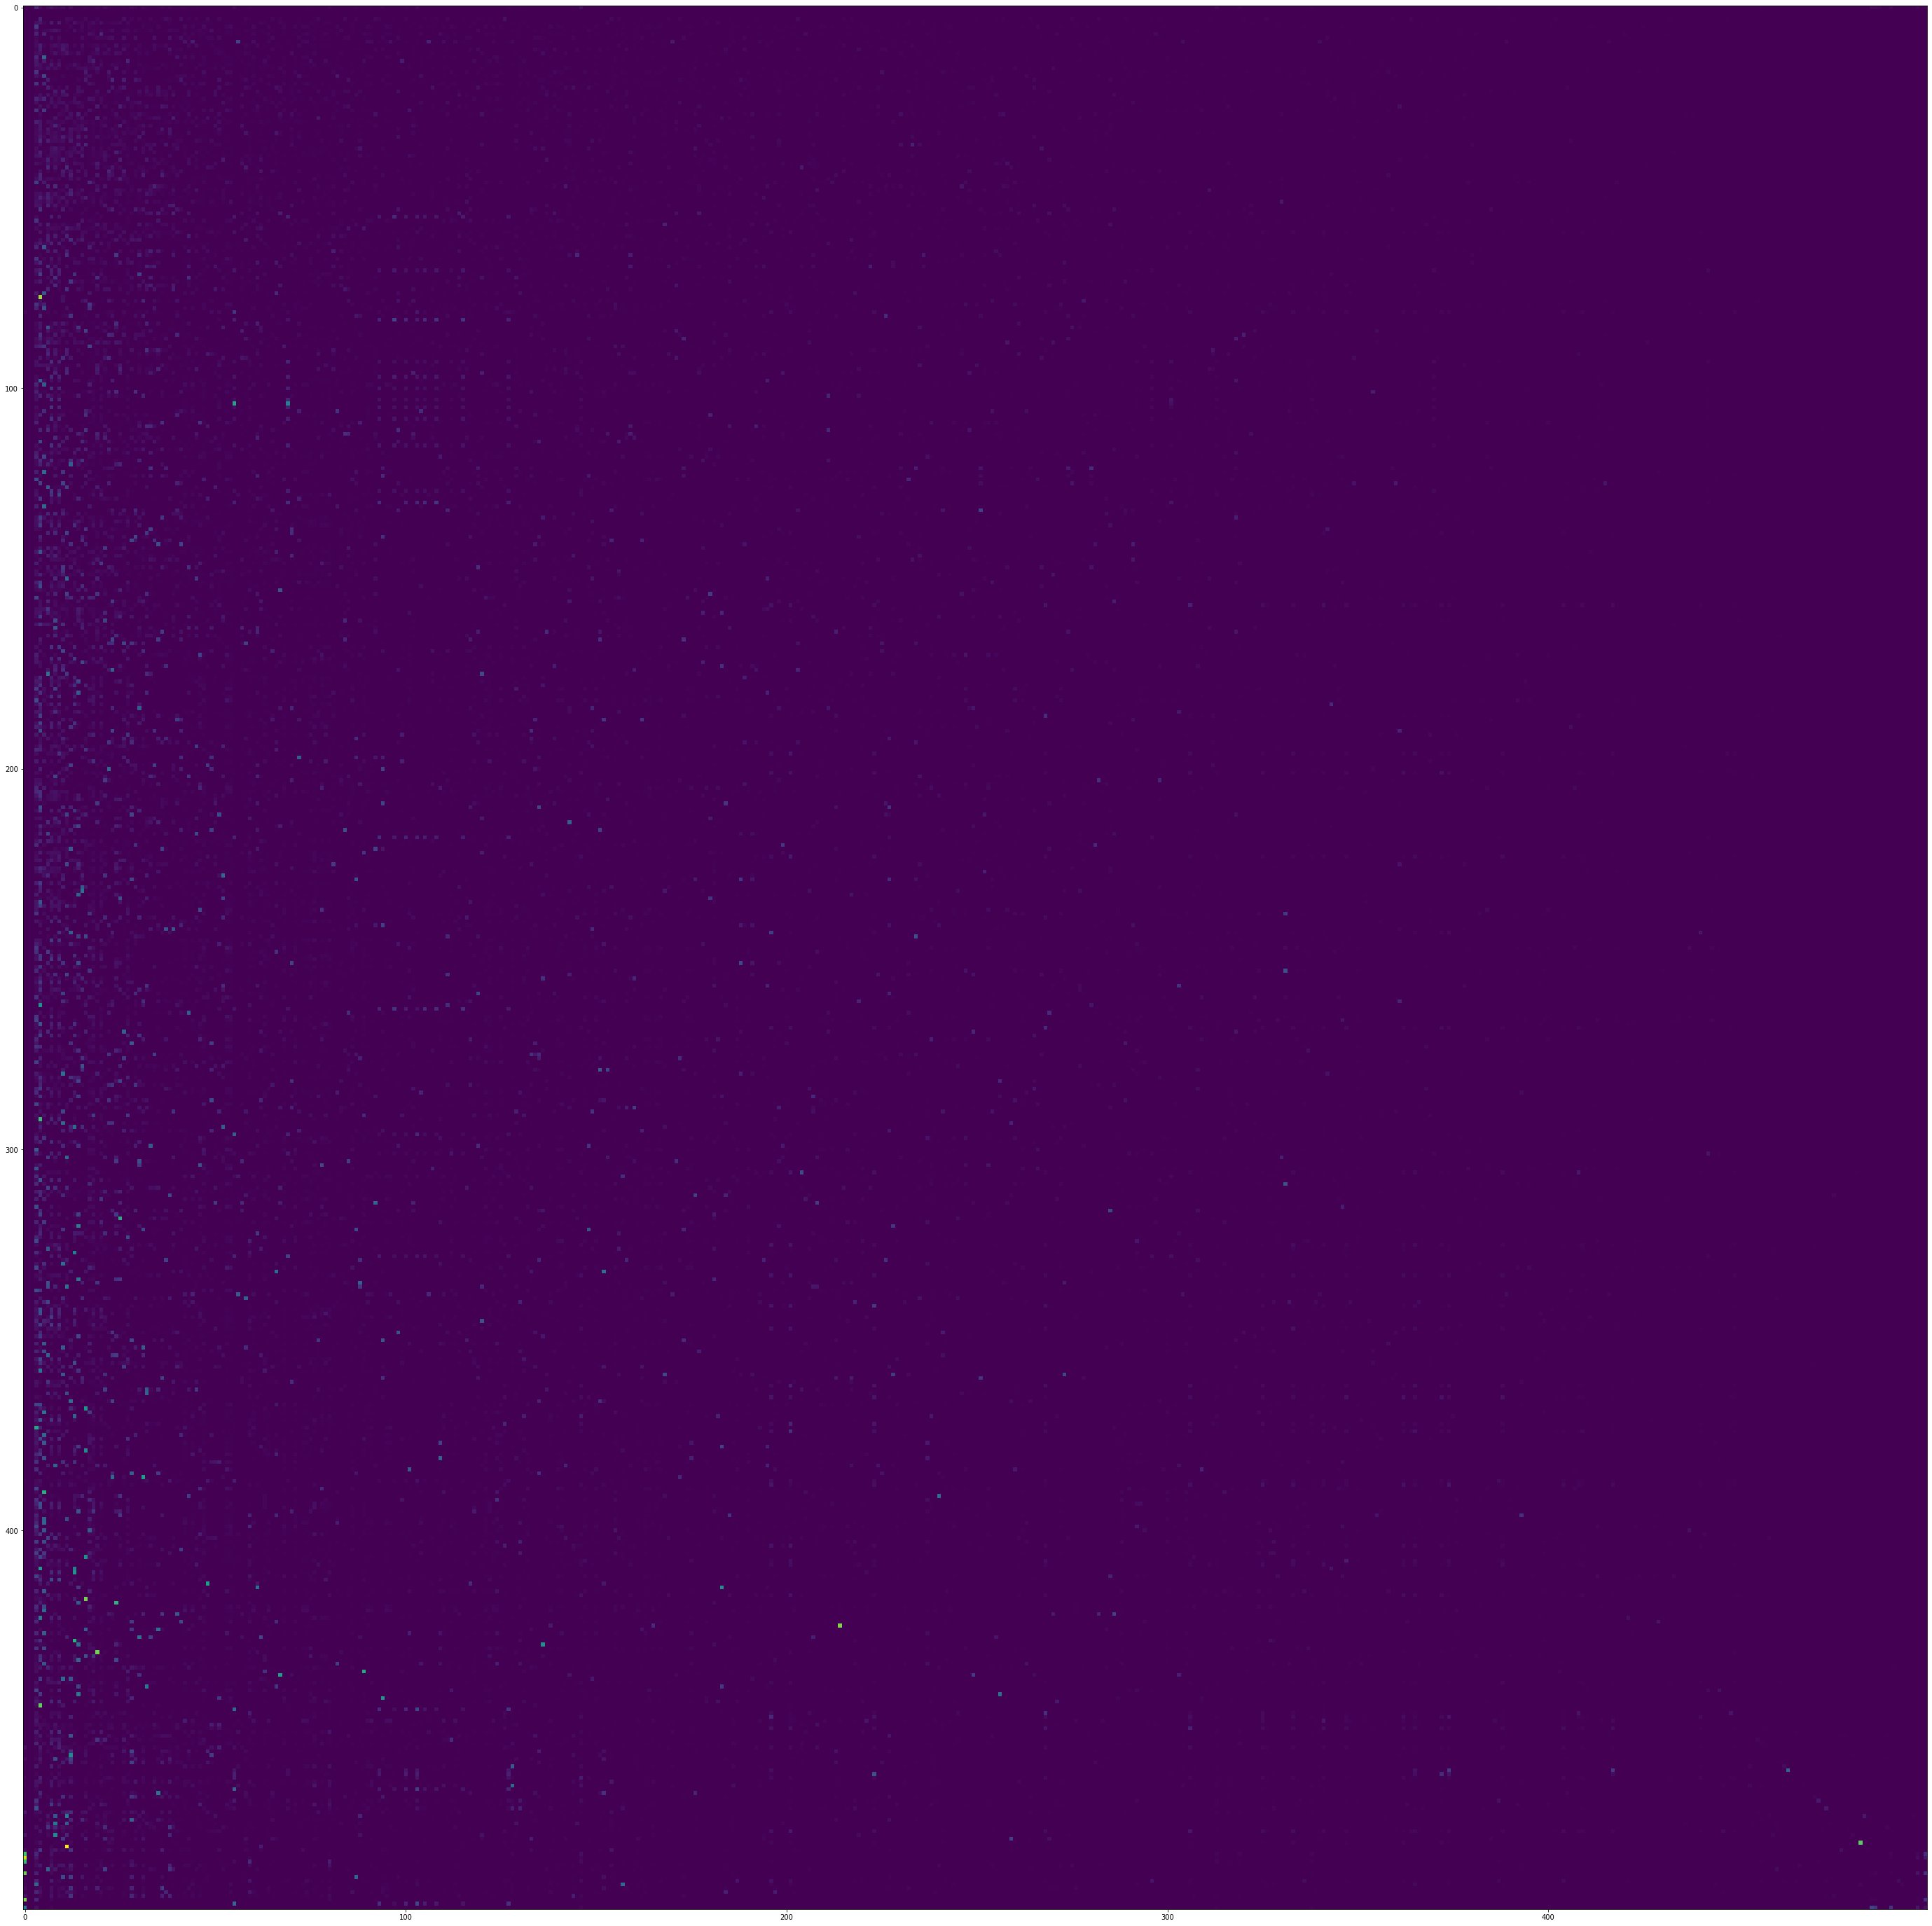

In [246]:
plt.figure(figsize=(50, 50))
plt.imshow(freq / (1 + freq.sum(axis=1)).reshape(-1, 1))

In [228]:
print(list(sp.id_to_piece(i) for i in range(sp.vocab_size())))

['<unk>', '<s>', '</s>', '▁', 's', '▁the', 'e', ',', 'a', '.', 't', 'o', 'n', '▁of', 'ed', 'y', 'd', '▁a', '▁in', 'u', '▁and', 'i', 'c', 'p', 'ing', 'er', 'b', '▁to', 'r', 'g', 'al', 'm', 'or', 'ar', 'in', 're', 'l', 'le', 'k', 'an', 'f', 'st', '▁S', 'ri', '▁A', 'en', '▁was', '▁f', 'h', 'w', 'on', 'th', 'ic', '▁re', '▁c', '1', '▁The', 'it', 'ch', '-', '▁B', 'ur', 'es', '▁for', '▁P', 'v', 'ly', 'ent', '▁w', '0', 'ation', '▁p', 'ter', '▁C', '▁M', '▁on', "'", 'ra', '▁is', '▁with', '▁(', 'ro', '▁19', 'at', 'us', 'il', '▁de', 'te', 'ad', '▁as', '▁F', '▁T', 'un', '5', 'ng', '▁G', '▁H', '9', 'ce', '▁by', '4', '▁be', 'is', '2', '▁20', '6', '▁In', 'el', '7', '▁he', '▁W', 'vi', '▁m', '▁D', 'la', '8', 'ir', 'se', '▁that', 'ver', 'ow', '▁e', '▁at', '▁E', '▁his', '▁con', 'L', '3', '"', 'as', '▁1', '▁from', '▁pro', 'li', 've', 'ck', 'ment', 'ul', '▁N', 'lo', '▁ma', '▁mo', 'am', 'ate', 'z', 'ol', ')', '▁se', 'x', 'et', '▁g', 'me', 'ne', 'id', 'j', '▁an', 'im', '▁"', 'ut', 'ill', 'ist', '▁R', 'ke', '▁

## Simple English wikipedia

some [link](https://github.com/LGDoor/Dump-of-Simple-English-Wiki)

# Calculating metrics

## Excess Entropy

Friendly reminder:

Suppose that we have a sequence of tokens $x_0, x_1, \ldots, x_{n-1}$.
We want to calculate $E(x_0, x_1, \ldots, x_{n-1})$

In original papers this metrics can be calculated only of some multidimensional random value, but not of sequence of numbers. 

So, $E(X_0, X_1, \ldots, X_{n-1}) = (n-1)\left(\frac{1}{n-1}\sum\limits_{i=0}^{n-1}H(X_0, X_1, \ldots, X_{i-1}, X_{i+1}, \ldots, X_{n-1}) - H(X_0, \ldots, X_{n-1})\right)$

The problem is how to calculate $H(\ldots)$.

First of all, let's suppose that $X_i$ depends only from $X_{i-1}$, then we can say that $H(X_0, X_1, \ldots, X_{n-1}) = H(X_0) + H(X_1|X_0) + \ldots + H(X_{n-1} | X_{n-2})$.

Now we want to calculate $H(a)$ and $H(b|a)$, but instead of r.v. $a$ and $b$ we have numbers. But also we have statistics retrived from our dataset and we have frequences of bigrams, so we can consider r.v. with binomial distributions with weights $\{p(a), 1 - p(a)\}$ for $H(a)$ $\{p(b|a), 1 - p(b|a)\}$ for $H(b|a)$.

Then 
* $H(a) = -p(a)\log p(a) - (1 - p(a)\log(1 - p(a))$
* $H(b|a) = -p(b|a)\log p(b|a) - (1 - p(b|a))\log(1 - p(b|a))$

How to calculate $H_i = H(x_0, \ldots, x_{i-1}, x_{i+1}, \ldots, x_{n-1})$ efficiently?

Let's denote $H = H(x_0, \ldots, x_{n-1})$

Notice that 
* if $0 < i < n - 1$ then $H_i = H - H(x_{i+1}|x_i) - H(x_i|x_{i-1}) + H(x_{i+1}|x_{i-1})$
* if i = 0 then $H_i = H - H(x_1|x_0) - H(x_0) + H(x_1)$
* if i = n - 1 then $H_i = H - H(x_{n-1}|x_{n-2})$

So we can easily calculate it in $O(n)$ time complexity.


In [318]:
def calculate_excess_entropy(
    texts: List[str], 
    freq: np.ndarray, 
    freq_first: np.ndarray, 
    sp: spm.SentencePieceProcessor
) -> np.ndarray:
    """
    texts: the list of str texts
    freq: a (vocab_size, vocab_size) numpy array, where (i, j) cell stores the number of occurences of ij (i followed by j) in texts
    freq_first: a (vocab_size,) numpy array, where in i-th cell stores the number of occurences of i-th token at the first position in sentence
    sp: pretrained sentencepieces tokenizer

    Returns
    - a (# of texts,) numpy array with excess entropy calculated for each text
    """

    eps = 1e-9
    def get_entropy(p):
        return -p * np.log(p + eps) - (1 - p) * np.log(1 - p)
    
    H = get_entropy(freq / (1 + freq.sum(axis=1)).reshape(-1, 1))
    H_first = get_entropy(freq_first / freq_first.sum())

    ee = np.zeros(len(texts), dtype=float)

    for i, text in tqdm(enumerate(texts)):
        x = sp.encode_as_ids(text)
        n = len(x)
        full_ee = 0
        sum_partial_ee = 0
        for i in range(n):
            if i == 0:
                full_ee += H_first[x[0]]
                sum_partial_ee += -H[ x[0], x[1] ] -H_first[x[0]] + H_first[x[1]]
            else:
                full_ee += H[ x[i - 1], x[i] ]
                if 0 < i < n - 1:
                    sum_partial_ee += -H[ x[i], x[i + 1] ] - H[ x[i - 1], x[i] ] + H[ x[i - 1], x[i + 1] ]
                elif i == n - 1:
                    sum_partial_ee += -H[ x[n - 2], x[n - 1] ]
        sum_partial_ee += n * full_ee
        ee[i] = sum_partial_ee - (n - 1) * full_ee
    
    return ee

In [319]:
ee = calculate_excess_entropy(
    texts,
    freq,
    freq_first,
    sp
)

Выходные данные были обрезаны до нескольких последних строк (5000).
-53.754006939452665 -39.54319061557908
-1.7762576727136192 -1.3829156616456295
-145.2449572658079 -102.35363003202656
-0.9076550563458081 -0.7543366109230139
-28.342811657248603 -21.697842591519475
-0.9297011044461936 -0.9055746110483582
-68.0294953550765 -48.5014163198648
-85.17738483884023 -61.64892392102047
-99.3669544003933 -72.64696627610829
-90.67673368661781 -69.96113048661937
-16.815937494122863 -12.276986156203293
-82.26013303110813 -62.72643580028671
-1.4236025773812226 -0.7876011921711346
-75.05772987667297 -57.64483305314934
-3.7118304913095344 -2.8178917643752257
-69.72140948932429 -50.327398663415806
-7.000566419401537 -4.946796003351949
-37.556425731554555 -26.141557525068492
-110.3885490183311 -78.30423887218058
-133.60503119202622 -88.78955363402201
-37.78020770521471 -26.999224359287837
-2.9511566384619314 -2.5583763131317383
-99.30202225860558 -74.35531884786178
-1.9627619079388872 -1.822737787616297

KeyboardInterrupt: ignored

In [263]:
A = np.arange(25).reshape(5, 5)
ids = [(0, 0), (1, 1), (2, 2)]

print(A)
print()
print(ids)
print()
# print(A[ids])

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]

[(0, 0), (1, 1), (2, 2)]



In [273]:
for x in ee:
    print(x)

Выходные данные были обрезаны до нескольких последних строк (5000).
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
